In [1]:
# Importing necessary libraries
import pandas as pd
#pd.set_option('display.max_rows', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
#from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
from google.colab import files
uploaded = files.upload()

Saving small_0_1.csv to small_0_1.csv


In [3]:
import pandas as pd
df_full = pd.read_csv('small_0_1.csv')

In [4]:
df_full_categorical = ['apache_3j_bodysystem', 'apache_2_bodysystem', 'ethnicity',
                       'icu_admit_source', 'gender', 'icu_stay_type', 'icu_type' ]

df_full_binary = ['elective_surgery', 'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache',
                  'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia',
                  'lymphoma', 'solid_tumor_with_metastasis', 'apache_post_operative']

df_full_multicat = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

df_full_numeric = ['age', 'bmi', 'height', 'weight', 'pre_icu_los_days','heart_rate_apache', 'map_apache','resprate_apache',
                   'temp_apache', 'd1_potassium_min', 'd1_potassium_max', 'h1_mbp_max',
                   'h1_mbp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_sysbp_max','h1_sysbp_min','d1_glucose_min',
                   'd1_glucose_max','h1_resprate_max','h1_resprate_min','h1_heartrate_max','h1_heartrate_min',
                   'd1_temp_max','d1_temp_min','d1_diasbp_max','d1_diasbp_min','d1_resprate_min','d1_resprate_max',
                   'd1_spo2_min','d1_spo2_max','h1_spo2_max','h1_spo2_min','d1_mbp_min','d1_mbp_max','d1_sysbp_min',
                   'd1_sysbp_max','d1_heartrate_max','d1_heartrate_min', 'apache_4a_hospital_death_prob',
                   'apache_4a_icu_death_prob']


In [5]:
# Assuming df is your DataFrame and 'target' is your target variable
X = df_full.drop('hospital_death', axis=1)  # Drop the target column
y = df_full['hospital_death']


In [6]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 4.8 MB/s eta 0:00:00


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_recall_fscore_support
# from xgboost import XGBClassifier
import pandas as pd

# Define categorical and numerical columns based on your dataset
categorical_cols = df_full_categorical
binary_cols = df_full_binary
multicat_cols = df_full_multicat
numeric_cols = df_full_numeric

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Define preprocessing for categorical and numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols),
        ('multi', 'passthrough', multicat_cols),
        ('binary', 'passthrough', binary_cols),
        ('num', StandardScaler(), numeric_cols)
    ]
)

# Process X_train for ADASYN
X_train_processed = preprocessor.fit_transform(X_train)

# Apply ADASYN to balance classes
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train_processed, y_train)

# Check class distribution after resampling
print("Class distribution after ADASYN:", pd.Series(y_resampled).value_counts())


Class distribution after ADASYN: hospital_death
0    39047
1    38647
Name: count, dtype: int64


In [8]:
print("Shape of X_resampled (Training Data After ADASYN):", X_resampled.shape)
print("Number of rows in X_resampled:", X_resampled.shape[0])
print("Number of columns in X_resampled:", X_resampled.shape[1])

# Confirm the shape of the target variable after resampling
print("Number of rows in y_resampled:", len(y_resampled))

Shape of X_resampled (Training Data After ADASYN): (77694, 96)
Number of rows in X_resampled: 77694
Number of columns in X_resampled: 96
Number of rows in y_resampled: 77694


### Decision Trees

In [9]:
# Full Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Initialize Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42)

# Train the model on the resampled training data
clf.fit(X_resampled, y_resampled)

# Transform X_test with the same preprocessor (no SMOTE needed for test set)
X_test_processed = preprocessor.transform(X_test)

# Predict on the test set
y_pred = clf.predict(X_test_processed)

# Evaluate the model
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nTest Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nTrain Accuracy Score:", clf.score(X_train_processed, y_train))


Confusion Matrix:
 [[11646  1351]
 [ 1106   887]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.90      0.90     12997
           1       0.40      0.45      0.42      1993

    accuracy                           0.84     14990
   macro avg       0.65      0.67      0.66     14990
weighted avg       0.84      0.84      0.84     14990


Test Accuracy Score: 0.8360907271514343

Train Accuracy Score: 1.0


In [10]:
clf.get_depth()

39

In [11]:
# Import necessary libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Define parameter grid with refined ranges
dt_params = {
    'max_depth': range(10, 41, 3),               # Depths from 10 to 41 in increments of 3
    'min_samples_split': range(50, 201, 50),     # Min samples from 50 to 200 in increments of 50
    'max_leaf_nodes': range(20, 101, 20)         # Max leaf nodes from 20 to 100 in increments of 20
}

# Initialize Decision Tree Classifier with balanced class weights and consistent random state
opt_tree = DecisionTreeClassifier(random_state=42, class_weight='balanced')

# Set up GridSearchCV with 5-fold cross-validation, using accuracy as the scoring metric
grid_tree = GridSearchCV(
    estimator=opt_tree,
    param_grid=dt_params,
    cv=5,                       # 5-fold cross-validation
    scoring='f1_weighted',
    n_jobs=-1                    # Use all available cores for efficiency
)

# Fit the grid search on the resampled training data
grid_tree.fit(X_resampled, y_resampled)

# Output the best parameters and corresponding cross-validation accuracy
print("Best Parameters:", grid_tree.best_params_)
print("Best Cross-Validation Accuracy:", grid_tree.best_score_)

# Retrieve the best model from GridSearchCV
best_tree = grid_tree.best_estimator_

# Evaluate model performance on training set
y_train_pred = best_tree.predict(X_resampled)
train_accuracy = accuracy_score(y_resampled, y_train_pred)
print("\nTrain Accuracy Score:", train_accuracy)

# Process test set with the same preprocessor (without resampling)
X_test_processed = preprocessor.transform(X_test)

# Predict and evaluate on the test set
y_test_pred = best_tree.predict(X_test_processed)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("\nTest Accuracy Score:", test_accuracy)

# Confusion Matrix and Classification Report on test set
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
print("\nClassification Report:\n", classification_report(y_test, y_test_pred))

# Optional: Additional metrics for better insight into class imbalance handling
from sklearn.metrics import precision_recall_fscore_support

precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_test_pred, average='binary')
print("\nPrecision (Class 1):", precision)
print("Recall (Class 1):", recall)
print("F1-Score (Class 1):", fscore)


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best Parameters: {'max_depth': 16, 'max_leaf_nodes': 100, 'min_samples_split': 200}
Best Cross-Validation Accuracy: 0.8672033365639086

Train Accuracy Score: 0.9012278940458722

Test Accuracy Score: 0.8629753168779186

Confusion Matrix:
 [[11806  1191]
 [  863  1130]]

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92     12997
           1       0.49      0.57      0.52      1993

    accuracy                           0.86     14990
   macro avg       0.71      0.74      0.72     14990
weighted avg       0.87      0.86      0.87     14990


Precision (Class 1): 0.4868591124515295
Recall (Class 1): 0.5669844455594582
F1-Score (Class 1): 0.5238757533611498


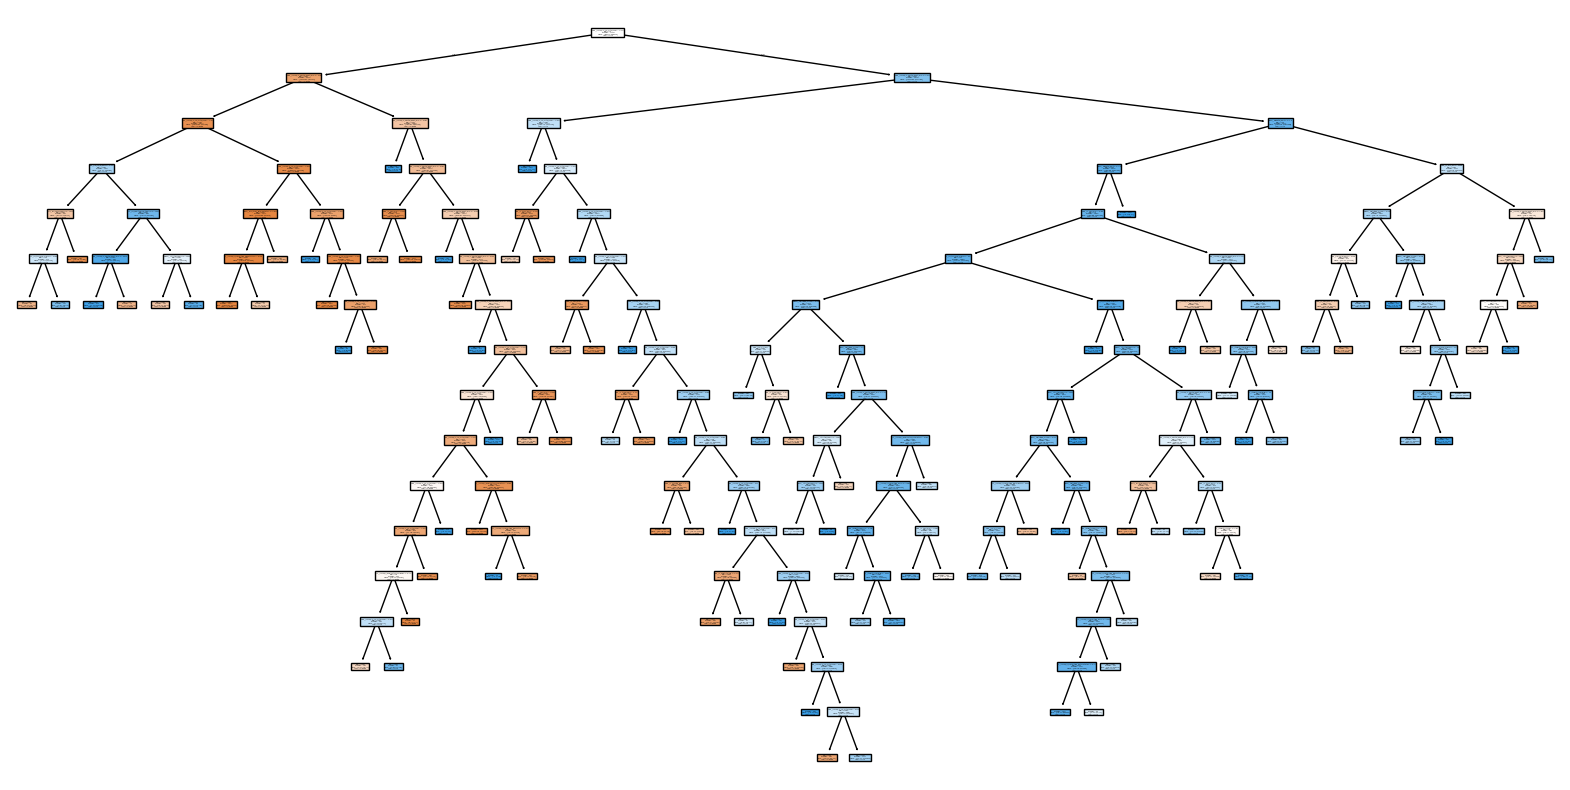

In [12]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Retrieve the best estimator (the best decision tree model from Grid Search)
#best_tree = grid_tree.best_estimator_

# Set up the plot
plt.figure(figsize=(20, 10))  # Adjust the figure size for readability

# Plot the tree
plot_tree(
    best_tree,
    filled=True,                      # Colors the nodes by class
    feature_names=preprocessor.get_feature_names_out(),  # Use feature names from preprocessing
    class_names=['No Death', 'Death'] # Replace with appropriate class names
                     # Display only the top levels for readability; change as needed
)

# Show the plot
plt.show()

In [13]:
best_tree.get_depth()

16

In [14]:
import pandas as pd

# Retrieve the best estimator from GridSearchCV
#best_tree = grid_tree.best_estimator_

# Get feature importances from the best model
feature_importances = best_tree.feature_importances_

# Create a DataFrame to display feature names with their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display the top features
print(feature_importance_df)

                               Feature  Importance
0        num__apache_4a_icu_death_prob    0.727295
1   num__apache_4a_hospital_death_prob    0.175191
2            binary__diabetes_mellitus    0.021267
3           cat__icu_type_Med-Surg ICU    0.015493
4             binary__intubated_apache    0.010779
..                                 ...         ...
91            binary__elective_surgery    0.000000
92             multi__gcs_motor_apache    0.000000
93                  cat__icu_type_SICU    0.000000
94             cat__icu_type_Neuro ICU    0.000000
95     cat__apache_2_bodysystem_Trauma    0.000000

[96 rows x 2 columns]


In [15]:
import matplotlib.pyplot as plt

# Filter to include only features with importance greater than 0
important_features_df = feature_importance_df[feature_importance_df['Importance'] > 0]

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(important_features_df['Feature'], important_features_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Best Decision Tree Model (Importance > 0)")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [16]:
# Predict probabilities and adjust threshold
y_test_prob = best_tree.predict_proba(X_test_processed)[:, 1]
threshold = 0.4
y_test_pred_adjusted = (y_test_prob >= threshold).astype(int)

# Evaluate the adjusted predictions
print("\nAdjusted Confusion Matrix (Test Data):\n", confusion_matrix(y_test, y_test_pred_adjusted))
print("\nAdjusted Classification Report (Test Data):\n", classification_report(y_test, y_test_pred_adjusted))


Adjusted Confusion Matrix (Test Data):
 [[11520  1477]
 [  731  1262]]

Adjusted Classification Report (Test Data):
               precision    recall  f1-score   support

           0       0.94      0.89      0.91     12997
           1       0.46      0.63      0.53      1993

    accuracy                           0.85     14990
   macro avg       0.70      0.76      0.72     14990
weighted avg       0.88      0.85      0.86     14990



### Random Forest Classifier

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

# Assuming X_resampled and y_resampled are the resampled data from SMOTE + Tomek Links
# Define the model
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# Define scoring metric focused on F1 for the minority class (class 1)
f1_minority = make_scorer(f1_score, pos_label=1)

In [18]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set up the GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring=f1_minority,  # Focuses on F1 for class 1
    cv=cv,
    n_jobs=-1,  # Use all available cores
    verbose=2
)

In [19]:
grid_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20], 'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 200]},
             scoring=make_scorer(f1_score, response_method='predict', pos_label=1),
             verbose=2)

In [20]:
# Best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 score for minority class: ", grid_search.best_score_)

# Predict on the original test set
best_rf = grid_search.best_estimator_
# Transform X_test using the same preprocessor pipeline
X_test_processed = preprocessor.transform(X_test)

# Now, use the transformed test set for prediction
y_pred = best_rf.predict(X_test_processed)

# Evaluate the performance
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

Best parameters found:  {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best F1 score for minority class:  0.9445304942725613
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     12997
           1       0.57      0.53      0.55      1993

    accuracy                           0.88     14990
   macro avg       0.75      0.74      0.74     14990
weighted avg       0.88      0.88      0.88     14990



In [21]:
# Evaluate model performance on training set
y_train_pred_rf = best_rf.predict(X_resampled)
train_accuracy_rf = accuracy_score(y_resampled, y_train_pred_rf)
print("\nTrain Accuracy Score:", train_accuracy_rf)

# Process test set with the same preprocessor (without resampling)
X_test_processed = preprocessor.transform(X_test)

# Predict and evaluate on the test set
y_test_pred_rf = best_rf.predict(X_test_processed)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print("\nTest Accuracy Score:", test_accuracy_rf)


Train Accuracy Score: 0.9972069915308776

Test Accuracy Score: 0.8845230153435624


In [22]:
# Get feature importances from the best Random Forest model
feature_importances = best_rf.feature_importances_

# Create a DataFrame to display feature names with their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': preprocessor.get_feature_names_out(),
    'Importance': feature_importances
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Display the top features
feature_importance_df

Feature  Importance
0               num__apache_4a_hospital_death_prob    0.102179
1                    num__apache_4a_icu_death_prob    0.091699
2                        binary__ventilated_apache    0.063231
3                         multi__gcs_verbal_apache    0.037559
4                           multi__gcs_eyes_apache    0.024173
..                                             ...         ...
91                  cat__ethnicity_Native American    0.000234
92  cat__apache_3j_bodysystem_Musculoskeletal/Skin    0.000219
93    cat__apache_2_bodysystem_Undefined Diagnoses    0.000113
94                                    binary__aids    0.000058
95         cat__apache_3j_bodysystem_Gynecological    0.000027

[96 rows x 2 columns]

In [23]:
# Filter to include only features with importance greater than 0
# Filter to include only features with importance greater than 0 and round the values

feature_importance_df['Importance'] = feature_importance_df['Importance'].round(2)

top_n = 25
top_features_df = feature_importance_df.head(top_n)
top_features_df

Feature  Importance
0   num__apache_4a_hospital_death_prob        0.10
1        num__apache_4a_icu_death_prob        0.09
2            binary__ventilated_apache        0.06
3             multi__gcs_verbal_apache        0.04
4               multi__gcs_eyes_apache        0.02
5                             num__age        0.02
6             binary__intubated_apache        0.02
7          cat__icu_admit_source_Floor        0.02
8           cat__icu_type_Med-Surg ICU        0.02
9     cat__apache_3j_bodysystem_Sepsis        0.02
10             multi__gcs_motor_apache        0.02
11                   num__d1_sysbp_min        0.02
12                    num__d1_spo2_min        0.02
13                num__d1_resprate_max        0.02
14           binary__diabetes_mellitus        0.01
15                num__resprate_apache        0.01
16                    num__h1_spo2_max        0.01
17                    num__d1_temp_min        0.01
18               num__d1_potassium_max        0.01
19                num__h1_resprate_max        0.01
20            cat__ethnicity_Caucasian        0.01
21                    num__h1_spo2_min        0.01
22                    num__temp_apache        0.01
23                     num__h1_mbp_min        0.01
24                num__h1_resprate_min        0.01

In [24]:
import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in Random Forest (Importance > 0)")
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.show()

In [25]:
top_features = [
    'num__apache_4a_hospital_death_prob',
    'num__apache_4a_icu_death_prob',
    'binary__ventilated_apache',
    'multi__gcs_verbal_apache',
    'cat__apache_3j_bodysystem_Sepsis',
    'multi__gcs_eyes_apache',
    'cat__icu_admit_source_Floor',
    'multi__gcs_motor_apache',
    'cat__icu_type_Med-Surg ICU',
    'binary__intubated_apache',
    'cat__icu_admit_source_Operating Room / Recovery',
    'num__age',
    'num__d1_sysbp_min',
    'binary__diabetes_mellitus',
    'cat__ethnicity_Caucasian',
    'num__d1_spo2_min',
    'num__d1_resprate_max',
    'num__resprate_apache',
    'num__h1_spo2_max',
    'binary__apache_post_operative',
    'binary__elective_surgery',
    'cat__gender_M',
    'cat__apache_3j_bodysystem_Respiratory',
    'num__pre_icu_los_days',
    'num__d1_temp_min'
]

In [26]:
# Convert X_resampled back to DataFrame and filter for the top 25 features
X_resampled_df = pd.DataFrame(X_resampled, columns=preprocessor.get_feature_names_out())
X_resampled_df = X_resampled_df[top_features]

# Step 4: Transform X_test without SMOTE and select only the top 25 features
X_test_processed = preprocessor.transform(X_test)
X_test_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())
X_test_df = X_test_df[top_features]

# Step 5: Set up Logistic Regression with GridSearchCV
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=500)
param_grid = {
'C': [0.01, 0.1, 1, 10, 100],
'penalty': ['l1', 'l2'],
'solver': ['liblinear', 'saga'],
'class_weight': ['balanced', {0: 1, 1: 2}, {0: 1, 1: 3}]
}
grid_search = GridSearchCV(log_reg, param_grid, scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2)

# Step 6: Fit GridSearchCV on the resampled training data with selected features
grid_search.fit(X_resampled_df, y_resampled)

# Step 7: Evaluate the best model on the test set
best_log_reg = grid_search.best_estimator_
y_test_pred = best_log_reg.predict(X_test_df)

print("Best parameters for Logistic Regression:", grid_search.best_params_)
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred))

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, y_test_pred)
print("Model Accuracy on Test Set:", accuracy)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters for Logistic Regression: {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.95      0.74      0.84     12997
           1       0.31      0.77      0.45      1993

    accuracy                           0.75     14990
   macro avg       0.63      0.76      0.64     14990
weighted avg       0.87      0.75      0.78     14990

Model Accuracy on Test Set: 0.7461641094062709


### KNN

In [27]:
from sklearn.neighbors import KNeighborsClassifier

# define function
knn = KNeighborsClassifier()
param_knn = { 'n_neighbors': range(3, 40, 3)}

# apply grid search:
grid_knn = GridSearchCV(knn, param_knn, cv = 5)
grid_knn.fit(X_resampled, y_resampled)

print(grid_knn.best_params_)
print(grid_knn.best_score_)



from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, classification_report

best_n_neighbors = grid_knn.best_params_['n_neighbors']

# Initialize and fit KNN with the best parameters
knn_best = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn_best.fit(X_resampled, y_resampled)

# Predict on the original test set
y_pred = knn_best.predict(X_test_processed)

# Calculate F1 scores
# Overall F1 score for both classes (averaged)
overall_f1 = f1_score(y_test, y_pred, average='weighted')  # Use 'weighted' for imbalance
print("Overall F1 Score (weighted):", overall_f1)

# F1 score for each class
f1_class_0 = f1_score(y_test, y_pred, pos_label=0)
f1_class_1 = f1_score(y_test, y_pred, pos_label=1)
print("F1 Score for Class 0:", f1_class_0)
print("F1 Score for Class 1:", f1_class_1)

# Alternatively, print a full classification report to see precision, recall, and F1 for each class
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


{'n_neighbors': 3}
0.8404381574598225
Overall F1 Score (weighted): 0.7583386102957433
F1 Score for Class 0: 0.8129953150313061
F1 Score for Class 1: 0.4019044951687439

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.71      0.81     12997
           1       0.28      0.72      0.40      1993

    accuracy                           0.72     14990
   macro avg       0.61      0.72      0.61     14990
weighted avg       0.85      0.72      0.76     14990



In [28]:
# Evaluate model performance on training set
y_train_pred_knn = knn_best.predict(X_resampled)
train_accuracy_knn = accuracy_score(y_resampled, y_train_pred_knn)
print("\nTrain Accuracy Score:", train_accuracy_knn)

# Process test set with the same preprocessor (without resampling)
X_test_processed = preprocessor.transform(X_test)

# Predict and evaluate on the test set
y_test_pred_knn = knn_best.predict(X_test_processed)
test_accuracy_knn = accuracy_score(y_test, y_test_pred_knn)
print("\nTest Accuracy Score:", test_accuracy_knn)


Train Accuracy Score: 0.910070275696965

Test Accuracy Score: 0.7150767178118745


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving survival_clean.csv to survival_clean (1).csv


In [ ]:
import pandas as pd
survival_model = pd.read_csv('survival_clean.csv')

In [ ]:
df_full_categorical = ['apache_3j_bodysystem', 'apache_2_bodysystem', 'ethnicity',
                       'icu_admit_source', 'gender', 'icu_stay_type', 'icu_type' ]

df_full_binary = ['elective_surgery', 'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache',
                  'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia',
                  'lymphoma', 'solid_tumor_with_metastasis', 'apache_post_operative']

df_full_multicat = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']

df_full_numeric = ['age', 'bmi', 'height', 'weight', 'pre_icu_los_days','heart_rate_apache', 'map_apache','resprate_apache',
                   'temp_apache', 'd1_potassium_min', 'd1_potassium_max', 'h1_mbp_max',
                   'h1_mbp_min', 'h1_diasbp_max', 'h1_diasbp_min', 'h1_sysbp_max','h1_sysbp_min','d1_glucose_min',
                   'd1_glucose_max','h1_resprate_max','h1_resprate_min','h1_heartrate_max','h1_heartrate_min',
                   'd1_temp_max','d1_temp_min','d1_diasbp_max','d1_diasbp_min','d1_resprate_min','d1_resprate_max',
                   'd1_spo2_min','d1_spo2_max','h1_spo2_max','h1_spo2_min','d1_mbp_min','d1_mbp_max','d1_sysbp_min',
                   'd1_sysbp_max','d1_heartrate_max','d1_heartrate_min', 'apache_4a_hospital_death_prob',
                   'apache_4a_icu_death_prob']


In [ ]:
import pandas as pd

# Assuming `df` is your DataFrame and `df_full_numeric` is your list of numeric columns
# Calculate the correlation matrix for numeric columns
correlation_matrix = survival_model[df_full_numeric].corr()

# Identify pairs with correlation > 0.8 (absolute value)
high_correlation_pairs = correlation_matrix.abs().unstack().sort_values(ascending=False)
high_correlation_pairs = high_correlation_pairs[high_correlation_pairs != 1]  # Exclude self-correlation

# Select only pairs with correlation above 0.8 and remove duplicates
high_corr_pairs_filtered = high_correlation_pairs[high_correlation_pairs > 0.8].drop_duplicates()

# Display the high correlation pairs
print(high_corr_pairs_filtered.head(20))

apache_4a_hospital_death_prob  apache_4a_icu_death_prob    0.879245
bmi                            weight                      0.873599
h1_mbp_min                     h1_diasbp_min               0.863820
h1_heartrate_min               h1_heartrate_max            0.853824
d1_diasbp_min                  d1_mbp_min                  0.852608
h1_diasbp_max                  h1_mbp_max                  0.838893
d1_mbp_max                     d1_diasbp_max               0.822802
h1_sysbp_min                   h1_mbp_min                  0.809260
d1_heartrate_max               heart_rate_apache           0.801530
dtype: float64


In [ ]:
# List of columns to drop based on high correlation
columns_to_drop = [
    'apache_4a_icu_death_prob',   # Keep apache_4a_hospital_death_prob
    'weight',                     # Keep bmi
    'h1_diasbp_min',              # Keep h1_mbp_min
    'h1_heartrate_min',           # Keep h1_heartrate_max
    'd1_diasbp_min',              # Keep d1_mbp_min
    'h1_diasbp_max',              # Keep h1_mbp_max
    'd1_diasbp_max',              # Keep d1_mbp_max
    'h1_sysbp_min',               # Keep h1_mbp_min
    'd1_heartrate_max'            # Keep heart_rate_apache
]

# Drop these columns from the DataFrame
survival_model_v1 = survival_model.drop(columns=columns_to_drop)

# Verify the columns have been removed
print("Remaining columns after removal:")
print(survival_model_v1.columns)

Remaining columns after removal:
Index(['age', 'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       'icu_admit_source', 'icu_stay_type', 'icu_type', 'pre_icu_los_days',
       'apache_post_operative', 'arf_apache', 'gcs_eyes_apache',
       'gcs_motor_apache', 'gcs_unable_apache', 'gcs_verbal_apache',
       'heart_rate_apache', 'intubated_apache', 'map_apache',
       'resprate_apache', 'temp_apache', 'ventilated_apache',
       'd1_heartrate_min', 'd1_mbp_max', 'd1_mbp_min', 'd1_resprate_max',
       'd1_resprate_min', 'd1_spo2_max', 'd1_spo2_min', 'd1_sysbp_max',
       'd1_sysbp_min', 'd1_temp_max', 'd1_temp_min', 'h1_heartrate_max',
       'h1_mbp_max', 'h1_mbp_min', 'h1_resprate_max', 'h1_resprate_min',
       'h1_spo2_max', 'h1_spo2_min', 'h1_sysbp_max', 'd1_glucose_max',
       'd1_glucose_min', 'd1_potassium_max', 'd1_potassium_min',
       'apache_4a_hospital_death_prob', 'aids', 'cirrhosis',
       'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'l

In [ ]:
!pip install statsmodels


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 16.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
# Define columns based on your dataset
df_full_categorical = ['apache_3j_bodysystem', 'apache_2_bodysystem', 'ethnicity',
                       'icu_admit_source', 'gender', 'icu_stay_type', 'icu_type']
df_full_binary = ['elective_surgery', 'arf_apache', 'gcs_unable_apache', 'intubated_apache', 'ventilated_apache',
                  'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression', 'leukemia',
                  'lymphoma', 'solid_tumor_with_metastasis', 'apache_post_operative']
df_full_multicat = ['gcs_eyes_apache', 'gcs_motor_apache', 'gcs_verbal_apache']
df_full_numeric = ['age', 'bmi', 'height', 'pre_icu_los_days', 'heart_rate_apache', 'map_apache',
                   'resprate_apache', 'temp_apache', 'd1_potassium_min', 'd1_potassium_max', 'h1_mbp_max',
                   'h1_mbp_min', 'h1_sysbp_max', 'd1_glucose_min',
                   'd1_glucose_max', 'h1_resprate_max', 'h1_resprate_min', 'h1_heartrate_max',
                   'd1_temp_max', 'd1_temp_min',  'd1_resprate_min',
                   'd1_resprate_max', 'd1_spo2_min', 'd1_spo2_max', 'h1_spo2_max', 'h1_spo2_min', 'd1_mbp_min',
                   'd1_mbp_max', 'd1_sysbp_min', 'd1_sysbp_max', 'd1_heartrate_min',
                   'apache_4a_hospital_death_prob']
# Exclude the target column
X = survival_model_v1.drop(columns=['hospital_death'])
# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), df_full_categorical),
        ('multi', OneHotEncoder(drop='first', handle_unknown='ignore'), df_full_multicat),
        ('num', 'passthrough', df_full_numeric),
        ('binary', 'passthrough', df_full_binary)
    ]
)
# Apply preprocessing transformations
X_processed = preprocessor.fit_transform(X)
# Convert the processed array back to a DataFrame for VIF calculation
transformed_columns = preprocessor.get_feature_names_out()
X_processed_df = pd.DataFrame(X_processed, columns=transformed_columns)
# Identify numeric columns in the transformed data
numeric_transformed_columns = [col for col in transformed_columns if any(num_col in col for num_col in df_full_numeric)]
# Standardize the identified numeric columns
scaler = StandardScaler()
X_processed_df[numeric_transformed_columns] = scaler.fit_transform(X_processed_df[numeric_transformed_columns])
# Check the processed DataFrame
X_processed_df.head()
from sklearn.feature_selection import VarianceThreshold
# Remove constant columns (near-zero variance)
vt = VarianceThreshold(threshold=1e-5)
X_reduced = vt.fit_transform(X_processed_df)
X_reduced_df = pd.DataFrame(X_reduced, columns=X_processed_df.columns[vt.get_support()])
# Remove duplicate columns (to avoid perfect multicollinearity)
X_reduced_df = X_reduced_df.loc[:, ~X_reduced_df.T.duplicated()]
# Standardize numeric columns
numeric_transformed_columns = [col for col in transformed_columns if any(num_col in col for num_col in df_full_numeric)]
scaler = StandardScaler()
X_reduced_df[numeric_transformed_columns] = scaler.fit_transform(X_reduced_df[numeric_transformed_columns])
# Function to calculate VIF and iteratively remove features with high VIF
def calculate_vif(df, threshold=5.0):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = df.columns
    vif_data["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif_data
# Iteratively remove features with VIF > threshold
while True:
    vif_df = calculate_vif(X_reduced_df)
    max_vif = vif_df['VIF'].max()
    if max_vif > 5.0:  # Set threshold for VIF
        # Identify the feature with the highest VIF
        feature_to_drop = vif_df.sort_values(by='VIF', ascending=False).iloc[0]['Feature']
        print(f"Dropping '{feature_to_drop}' with VIF: {max_vif}")
        # Drop the feature with the highest VIF from the dataframe
        X_reduced_df = X_reduced_df.drop(columns=[feature_to_drop])
    else:
        break
# Display final features and their VIFs
print("Final set of features and VIFs:")
print(calculate_vif(X_reduced_df))


<ipython-input-41-dfd2a352df47>:108: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reduced_df[numeric_transformed_columns] = scaler.fit_transform(X_reduced_df[numeric_transformed_columns])


Dropping 'cat__apache_2_bodysystem_Renal/Genitourinary' with VIF: 99.84121827819966
Dropping 'multi__gcs_motor_apache_6.0' with VIF: 45.749088699032136
Dropping 'multi__gcs_eyes_apache_4.0' with VIF: 18.84534991960476
Dropping 'binary__apache_post_operative' with VIF: 11.837932329718853
Dropping 'cat__ethnicity_Caucasian' with VIF: 7.2976107004426325
Dropping 'cat__icu_type_Med-Surg ICU' with VIF: 6.070907564538821
Dropping 'cat__icu_admit_source_Operating Room / Recovery' with VIF: 5.694445259778659
Final set of features and VIFs:
                                       Feature       VIF
0   cat__apache_3j_bodysystem_Gastrointestinal  1.397072
1      cat__apache_3j_bodysystem_Genitourinary  1.091610
2      cat__apache_3j_bodysystem_Gynecological  1.037064
3      cat__apache_3j_bodysystem_Hematological  1.032835
4          cat__apache_3j_bodysystem_Metabolic  1.503967
..                                         ...       ...
78                     binary__hepatic_failure  1.420627
79    

In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.5/94.5 kB 7.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=e5a3ba4c2c7016ed1045dac3bd9aca24739699ad52fdd0caa0a8d30e238f4129
  Stored in directory: /root/.cache/pip/wheels/25/cc/e0/ef2969164144c899fedb22b338f6703e2b9cf46eeebf254991
Successfully built autograd-gamma


In [ ]:
# Verify if 'pre_icu_los_days' is present in the final dataset, add it if necessary
if 'pre_icu_los_days' not in X_reduced_df.columns:
    survival_data['pre_icu_los_days'] = survival_model_v1['pre_icu_los_days']

# Now try fitting the model again
from lifelines import CoxPHFitter

# Fit the Cox proportional hazards model
cph = CoxPHFitter()
cph.fit(survival_data, duration_col='pre_icu_los_days', event_col='hospital_death')

# Print the summary of the Cox model to show hazard ratios and significance
print("Cox Proportional Hazards Model Summary:")
cph.print_summary()


/usr/local/lib/python3.10/dist-packages/lifelines/utils/__init__.py:1163: ConvergenceWarning: Column num__pre_icu_los_days has high sample correlation with the duration column. This may harm convergence. This could be a form of 'complete separation'.     See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/lifelines/fitters/coxph_fitter.py:1614: ConvergenceWarning: Newton-Raphson failed to converge sufficiently. Please see the following tips in the lifelines documentation: https://lifelines.readthedocs.io/en/latest/Examples.html#problems-with-convergence-in-the-cox-proportional-hazard-model
  warnings.warn(


Cox Proportional Hazards Model Summary:


<lifelines.CoxPHFitter: fitted with 91713 total observations, 83798 right-censored observations>
             duration col = 'pre_icu_los_days'
                event col = 'hospital_death'
      baseline estimation = breslow
   number of observations = 91713
number of events observed = 7915
   partial log-likelihood = -67181.28
         time fit was run = 2024-11-12 18:25:58 UTC

---
                                                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                                       
cat__apache_3j_bodysystem_Gastrointestinal     -0.14      0.87      0.05           -0.24           -0.05                0.78                0.95
cat__apache_3j_bodysystem_Genitourinary        -0.09      0.92      0.10           -0.28            0.10                0.76                1.11
cat__apache_3j_bodysystem_Gynecological        -1.55      0.21      0.78           -3.07           -0.03                0.05                0.97
cat__apache_3j_bodysystem_Hematological         0.84      2.33      0.10            0.64            1.05                1.90                2.85
cat__apache_3j_bodysystem_Metabolic            -1.15      0.32      0.10           -1.35           -0.95                0.26                0.39
cat__apache_3j_bodysystem_Musculoskeletal/Skin  1.34      3.80      0.23            0.89            1.79                2.43                5.96
cat__apache_3j_bodysystem_Neurological          0.40      1.50      0.04            0.32            0.49                1.38                1.63
cat__apache_3j_bodysystem_Respiratory           0.02      1.02      0.04           -0.05            0.10                0.95                1.10
cat__apache_3j_bodysystem_Sepsis               -0.01      0.99      0.04           -0.08            0.06                0.93                1.07
cat__apache_3j_bodysystem_Trauma                0.40      1.49      0.06            0.28            0.51                1.33                1.67
cat__apache_2_bodysystem_Undefined Diagnoses   -0.90      0.41      0.31           -1.51           -0.29                0.22                0.75
cat__apache_2_bodysystem_Undefined diagnoses   -1.27      0.28      0.15           -1.57           -0.97                0.21                0.38
cat__ethnicity_Asian                           -0.36      0.70      0.11           -0.57           -0.15                0.56                0.86
cat__ethnicity_Hispanic                        -0.22      0.80      0.06           -0.34           -0.10                0.71                0.90
cat__ethnicity_Native American                  0.50      1.65      0.10            0.30            0.70                1.35                2.02
cat__ethnicity_Other/Unknown                   -0.16      0.86      0.06           -0.27           -0.04                0.76                0.96
cat__icu_admit_source_Floor                    -0.56      0.57      0.04           -0.63           -0.49                0.53                0.61
cat__icu_admit_source_Other Hospital            1.09      2.98      0.06            0.97            1.22                2.64                3.38
cat__icu_admit_source_Other ICU                 1.38      3.99      0.09            1.21            1.56                3.35                4.76
cat__gender_M                                   0.07      1.08      0.03            0.01            0.14                1.01                1.15
cat__icu_stay_type_readmit                      0.45      1.57      0.11            0.22            0.67                1.25                1.96
cat__icu_stay_type_transfer                    -0.44      0.64      0.05           -0.53           -0.35                0.59                0.71
cat__icu_type_CSICU                             0.21      1.23      0.06            0.09            0.32                1.10         